# Master Admission

Take a look at the data in "admit-train.csv". The attribute "admit" indicates whether a student has been admitted to a Master's course. The attributes "gre" and "gpa" contain the results of certain exams. The attribute "rank" represents the reputation rank of the student's current university, where smaller ranks correspond to higher reputation.

In [1]:
import pandas as pd

# Read data into dataframe
df_train = pd.read_csv("admit-train.csv")

# Show data
df_train.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


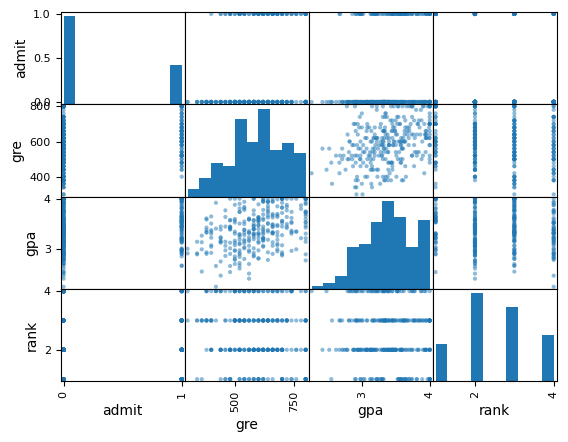

In [2]:
# create pairplot and get an overview of variable dependencies and distributions
pd.plotting.scatter_matrix(df_train);

## a)

Name the dependent variable and the independent variables.  
Which scales of measurement do the variables belong to? (e.g. nominal, ordinal, interval or ratio)

- a) 
- dependent: admit
- independent: gre, gpa, rank
- b)
- admit -> categorical (nominal), gre -> interval, gpa -> interval, rank -> ordinal (intervals between ranks are not necessarily equal)

## b)

Use the statsmodels module and train a generalized linear model on the data from "admit-train.csv". 

In [3]:
import statsmodels.formula.api as smf

# Mark "rank" as categorical
df_train["rank"] = df_train["rank"].astype("category")

# Define and fit a model
logreg = smf.logit("admit ~ gre + gpa + rank", data=df_train)
result = logreg.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.547548
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  299
Model:                          Logit   Df Residuals:                      293
Method:                           MLE   Df Model:                            5
Date:                Sat, 09 Nov 2024   Pseudo R-squ.:                  0.1129
Time:                        10:07:37   Log-Likelihood:                -163.72
converged:                       True   LL-Null:                       -184.56
Covariance Type:            nonrobust   LLR p-value:                 6.846e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.8711      1.415     -3.444      0.001      -7.643      -2.099
rank[T.2]     -0.6255      0.

**Observation**: The categorical variable "rank" is represented by three different variables which indicate whether the rank has a certain value:
$$
rank[T.i] = \mathbb{I}[rank = i]
$$
For $rank = 1$, we don't need another variable since this case can be inferred if all other rank-variables are zero.

Which coefficients are statistically significant for a level of $\alpha=0.05$? 

## c)

Interpret the coefficients:

- a coefficient is called statistically significant if its P-value is less than 0.05 (alpha)
- Intercept -> statistically significant
- rank[T.3] -> statistically significant
- rank[T.4] -> statistically significant
- gre -> statistically significant
- gpa -> statistically significant

## d)

Test the significance of the attribute "rank" by using a Wald test. 

Is the attribute "rank" statistically significant w.r.t. a level of $\alpha = 5\%$?

- Answer: Yes, since the p-value (0.000187) is < than the P-value. So we reject the Null-Hypothesis that all ranks are equal to zero
- Additionally, since our Chi-squared value is very large (>7.81 critical value), it suggests strong evidence against the Null-Hypothesis 

In [4]:
# Specify the restrictions as a list of strings and pass it to "r_matrix"
wald_test_result = result.wald_test(
  	"(rank[T.2] = 0, rank[T.3] = 0, rank[T.4] = 0)", 
  	scalar=True
)
print(f"Test statistic (chi^2_{int(wald_test_result.df_denom)}-distributed): {wald_test_result.statistic}")
print(f"p-value of the statistic: {wald_test_result.pvalue}")

Test statistic (chi^2_3-distributed): 19.79297717438745
p-value of the statistic: 0.0001873631214018955


## e)

In order to gain a better understanding of the model, have a look at the predicted probabilities of some data points. Adjust only one parameter and keep the others constant. For example, keep "gre" and "gpa" constant (mean value), while varying "rank".

In [11]:
# TODO
import statsmodels.api as sm

gre_mean = df_train['gre'].mean()
gpa_mean = df_train['gpa'].mean()

rank_levels = [1, 2, 3, 4]

predict_data = pd.DataFrame({
    'gre': gre_mean,
    'gpa': gpa_mean,
    'rank': pd.Categorical(rank_levels)  # Set rank as categorical to match model expectations
})

predict_data['predicted_prob'] = result.predict(predict_data)

print(predict_data[['rank', 'predicted_prob']])

  rank  predicted_prob
0    1        0.514788
1    2        0.362094
2    3        0.187661
3    4        0.164361


## f)

Find the McFadden ratio and interpret the results.

In [ ]:
# TODO

- McFadden $R^2$ = $1 - \frac{Loglikelihood}{LL-Null}$
- In our case: $R^2 = 1-\frac{-163.72}{-184.56}=0.113$
- values between 0.2 ~ 0.4 are considered excellent fit for discrete choise models
- In our case: 0.113.
- A value of 0.113 indicates that this model explains a modest portion of the variation in the dependent variable, suggesting that while the predictors (such as "gre", "gpa", and "rank") do have some explanatory power, they may not fully capture the factors influencing the outcome (admission).
- In practice: Lower values of McFadden’s (like 0.1) suggest that the model might be missing important predictors or that the relationship between predictors and outcome is weak. Higher values (closer to 1) indicate a stronger fit.

## g)

Load the test data from *admit-test.csv* and predict the probability.

In [14]:
# TODO
from sklearn.metrics import confusion_matrix

df_test = pd.read_csv("admit-test.csv")
df_test["rank"] = df_test["rank"].astype("category")

df_test['predicted_prob'] = result.predict(df_test)

threshold = 0.5
df_test['predicted_admit'] = (df_test['predicted_prob'] >= threshold).astype(int)

conf_matrix = confusion_matrix(df_test['admit'], df_test['predicted_admit'])

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[58  8]
 [26  9]]


The confusion matrix output will look like this:

- [True Negatives, False Positives
- False Negatives, True Positives]

Each value indicates the count of predictions that fall into each category:

True Negatives (TN): Correctly predicted as not admitted.
False Positives (FP): Incorrectly predicted as admitted.
False Negatives (FN): Incorrectly predicted as not admitted.
True Positives (TP): Correctly predicted as admitted.

## h)

Compute the accuracy 
$$
\frac{TP + TN}{TP + TN + FP + FN}
$$
of your trained model on the test set.

In [16]:
# TODO
TN, FP, FN, TP = conf_matrix.ravel()  # Unpack confusion matrix values
accuracy = (TP + TN) / (TP + TN + FP + FN)

print("Accuracy of the model on the test set:", accuracy)

Accuracy of the model on the test set: 0.6633663366336634
